In [2]:
import os
from glob import glob
import gzip
import zlib
from tqdm import tqdm
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import pandas as pd
import xgboost as xgb
import transformers
import emoji
from transformers import AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
#
#import emoji
#from emoji import unicode_codes
#help(unicode_codes)

In [3]:
DATASETS_DIR = "./data/"
ALL_CORPUS = glob(DATASETS_DIR + "*/*.txt") # tokenization/vectorization purposes
LANGUAGES = set(os.listdir(DATASETS_DIR)).difference({"Test.csv", "SampleSubmission.csv"})
COLUMN_NAMES = ["Word", "POS"] # since txt files have no headers

#print("...Data counts....")
#print(f"Num datasets in entire corpus: {len(ALL_CORPUS)}\nTrain datasets: {len(TRAIN_DATASETS)}\nVal datasets: {len(VAL_DATASETS)}\
#	\nTest datasets: {len(TEST_DATASETS)}")
#print(f"Train datasets list:\n{TRAIN_DATASETS}")
## Merge all language corpus for vectorization
print(f"Available languages: {LANGUAGES}")

# corpus analysis: num tokens, max token length each language(train,val,test)
# count vectorization (BoW) for each lang, count vectors to dense embedding, concat all lang vectors into
# one vector embedding and train a base model on these and test
# test tfidf approach and repeat above steps
# use of pretrained word embeddings XLM-roberta models, existing similar hf model for these langs
# train a custom tokenizer (BPE, sentencepiece,)

Available languages: {'kin', 'pcm', 'ewe', 'wol', 'fon', 'ibo', 'bbj', 'xho', 'twi', 'swa', 'sna', 'lug', 'mos', 'hau', 'zul', 'yor', 'nya', 'bam'}


In [4]:
# load entire corpus for all languages
corpus_df = pd.DataFrame(columns=COLUMN_NAMES+["LANG", "split"])
for dset in ALL_CORPUS:
	temp_df = pd.DataFrame(columns=COLUMN_NAMES+["LANG", "split"])
	temp_data = {"Word": [], "POS": []}
	with open(dset, "r") as f:
		lines = f.readlines()
		for line in lines:
			if len(line) <= 1:
				continue
			line_split = line.strip().split(" ")
			temp_data["Word"].append(line_split[0].lower())
			temp_data["POS"].append(line_split[1])
		temp_df["Word"] = temp_data["Word"]
		temp_df["POS"] = temp_data["POS"]
		temp_df["LANG"] = dset.split("/")[-2]
		temp_df["split"] = dset.split("/")[-1][:-4]
		corpus_df = pd.concat([corpus_df, temp_df], axis=0)
		#print(f"Cumm. retry df shape: {corpus_df.shape}")

print(f"Corpus df shape: {corpus_df.shape}")
print(f"Corpus df num langs: {corpus_df['LANG'].nunique()}")

# drop duplicates
corpus_df = corpus_df.drop_duplicates(keep=False)
print(f"De-duped corpus: {corpus_df.shape}")

# reset index
corpus_df.reset_index(drop=True, inplace=True)

Corpus df shape: (654842, 4)
Corpus df num langs: 18
De-duped corpus: (99636, 4)


In [5]:
token_len = np.vectorize(len) # map(len, corpus_df["Word"].values)
token_lengths = token_len(corpus_df["Word"].values)
print(f"Min token len: {min(token_lengths)}\nMax token len: {max(token_lengths)}\nVocab size: {token_lengths.shape}")
corpus_df.head()

Min token len: 1
Max token len: 38
Vocab size: (99636,)


,Word,POS,LANG,split
0,chetekwa,VERB,ibo,dev
1,ịma,VERB,ibo,dev
2,adịrịrị,VERB,ibo,dev
3,ụkwa,NOUN,ibo,dev
4,jighị,VERB,ibo,dev


<Axes: title={'center': 'Top 60 Tokens by Frequency'}, xlabel='Word', ylabel='Frequency'>

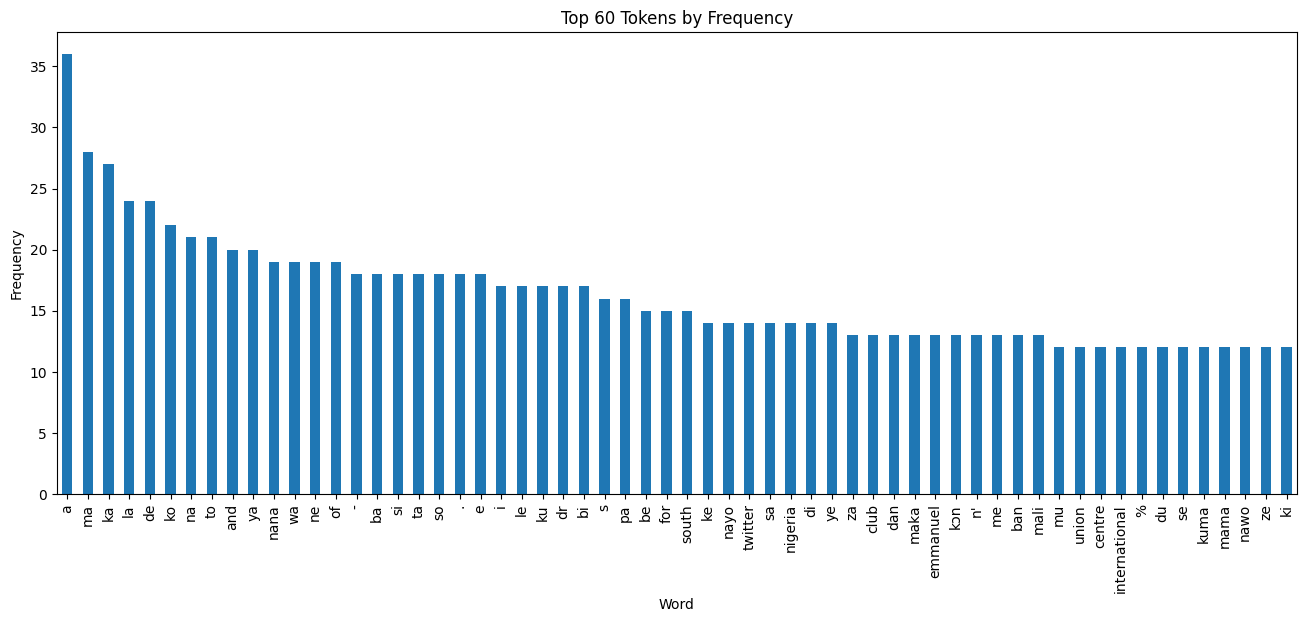

In [8]:
## token frequencies
plt.figure(figsize=(16, 6))
plt.title("Top 60 Tokens by Frequency")
plt.ylabel("Frequency")
corpus_df["Word"].value_counts()[:60].plot(kind="bar")

In [7]:
## Check for any non string or digit characters
non_str_chars = corpus_df[corpus_df["Word"].apply(lambda x: x in emoji.EMOJI_DATA)]
print(non_str_chars.shape, corpus_df.shape)
# Drop emojis from corpus
corpus_df = corpus_df[corpus_df["Word"].apply(lambda x: x not in emoji.EMOJI_DATA)]
corpus_df = corpus_df[~corpus_df["Word"].apply(lambda x: x.isdigit())]
# drop digits/numbers from copus
print(corpus_df.shape)
## Save preprocessed data to disk
#corpus_df.to_csv("corpus_df.csv", index=False)
non_str_chars.head()

(2, 4) (99636, 4)
(97830, 4)


,Word,POS,LANG,split
53102,❤,PUNCT,xho,train
53103,👍,PUNCT,xho,train


In [9]:
"""
test_data = corpus_df[corpus_df["LANG"] == "xho"]
print(f"Xho test data shape: {test_data.shape}")
word_vectors, vectorizer = generate_word_vectors(test_data["Word"], vectorizer="tfidf")
dense_word_vector_array = word_vectors.toarray()
word_vectors.shape
"""

'\ntest_data = corpus_df[corpus_df["LANG"] == "xho"]\nprint(f"Xho test data shape: {test_data.shape}")\nword_vectors, vectorizer = generate_word_vectors(test_data["Word"], vectorizer="tfidf")\ndense_word_vector_array = word_vectors.toarray()\nword_vectors.shape\n'

In [10]:
"""
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, random_state=42)
svd.fit(word_vectors)
"""

'\nfrom sklearn.decomposition import TruncatedSVD\n\nsvd = TruncatedSVD(n_components=20, random_state=42)\nsvd.fit(word_vectors)\n'

In [11]:
class Embedding:
	def __init__(self, word, vector):
		"""Pair a word with its corresponding learned embedding."""
		self.word = np.asarray(word)
		self.vector = np.array(vector) if not isinstance(vector, np.ndarray) else vector
		self.vector = np.amax(self.vector, axis=1)
		self.word_vector = []
		
		assert self.word.shape[0] == self.vector.shape[0]
	
		for i in range(self.word.shape[0]):
			self.word_vector.append([self.word[i], self.vector[i]])

	def __repr__(self):
		return f"embedding({np.asarray(self.word_vector)})"

	def __str__(self):
		return self.word
	

#svd_vec = svd.transform(vectorizer.transform(test_data["Word"][:10]))
#embedding = Embedding(test_data["Word"][:10], svd_vec)
#embedding

In [12]:
#fig, ax = plt.subplots()
#for idx, point in enumerate(dense_word_vector_array):
#	component = dense_word_vector_array[idx, 0:]
#	print(component.shape)
#	cols = np.array([i for i in range(component.shape[0])]) #dense_word_vector_array[idx, 0]
#	ax.scatter(component, cols)
#plt.show()
#plt.scatter(dense_word_vector_array[:,0], dense_word_vector_array) #[np.nonzero(dense_word_vector_array)]
test_df = pd.read_csv(os.path.join(DATASETS_DIR, "Test.csv"))
test_df["Word"] = test_df["Word"].apply(lambda x: x.lower())

In [13]:
def generate_word_vectors(data, vectorizer="tfidf"):
	"""Create word vectors for the input data

	vectorize accepts either `tfidf` or `count_vectorize` as arguments.
	Args:
		data: list of text to be vectorized
		vectorizer: whether to use `tfidf` vectorizer or `count_vectorizer`

	Returns:
		- sparse matrix of word vectors.
		- word vectorizer object
	"""
	if vectorizer == "tfidf":
		word_vectorizer = TfidfVectorizer(
			min_df=1,
			analyzer="char",
			max_features=50_000,
			ngram_range=(1, 4)
		)
		word_vectors = word_vectorizer.fit_transform(data)
		return word_vectors, word_vectorizer
	else:
		word_vectorizer = CountVectorizer(
			min_df=1,
			analyzer="char",
			max_features=50_000,
			ngram_range=(1, 6)
		)
		word_vectors = word_vectorizer.fit_transform(data)
		return word_vectors, word_vectorizer

## split data
groups = corpus_df['LANG']#.unique()
#all_corpus = corpus_df["Word"].tolist()
#all_corpus.extend(test_df["Word"].tolist())
#print(len(all_corpus))
feature_vectors, vectorizer = generate_word_vectors(corpus_df["Word"].values, vectorizer="tfidf") #corpus_df["Word"]
test_vectors = vectorizer.transform(test_df["Word"])
#feature_vectors = all_vectors[:corpus_df.shape[0]]
#print(feature_vectors.shape, test_vectors.shape)
label_encoder = LabelEncoder()
corpus_df["POS"] = label_encoder.fit_transform(corpus_df["POS"])
labels = corpus_df["POS"]
skfold = StratifiedGroupKFold(n_splits=5, shuffle=False)#, random_state=42) #17 splits

In [33]:
## Model training: BASE MODEL
xgb_model = xgb.XGBClassifier(
	max_depth=7,
	colsample_bytree=0.9,
	subsample=0.9,
	objective="multi:softprob",
	n_estimators=150,
	learning_rate=0.1,
	random_state=42
)
#xgb_model.predict() #predict_proba()[:, 1]
lr_model = LogisticRegression(C=8, random_state=42, max_iter=1000)

scores = []
for i, (train_idx, val_idx) in enumerate(skfold.split(feature_vectors, labels, groups=groups)):#, groups)):
	x_train, y_train = feature_vectors[train_idx], np.take(labels, train_idx, axis=0)
	x_val, y_val = feature_vectors[val_idx], np.take(labels, val_idx, axis=0)
	lr_model.fit(x_train, y_train)
	score = accuracy_score(y_val, lr_model.predict(x_val))
	scores.append(score)
	print(f"Fold {i} score: {score}")
print(f"Average accuracy: {np.mean(scores)}")

Fold 0 score: 0.5712152881457151
Fold 1 score: 0.603181870207165


/Users/smugisha/Downloads/POS_tagging/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2 score: 0.5536523929471032
Fold 3 score: 0.4063505999414691
Fold 4 score: 0.41887561899213516
Fold 5 score: 0.3776726584673605
Fold 6 score: 0.44197756923781184


/Users/smugisha/Downloads/POS_tagging/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 7 score: 0.4267923856964953


/Users/smugisha/Downloads/POS_tagging/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 8 score: 0.35265438786565545
Fold 9 score: 0.4518698060941828


/Users/smugisha/Downloads/POS_tagging/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 10 score: 0.3897584541062802
Fold 11 score: 0.3391003460207612
Fold 12 score: 0.2808176749948379
Fold 13 score: 0.38791615289765724
Fold 14 score: 0.4187517184492714
Fold 15 score: 0.3962018730489074
Fold 16 score: 0.4123854484865315
Fold 17 score: 0.39629507112140255
Average accuracy: 0.4236371842622635


#### 2. gzip compression, nearest neighbour approach

In [14]:
corpus_df.shape, test_df.shape
print(f"Test_df head:\n{test_df.head()}")
print(f"corpus_df head:\n{corpus_df.head()}")
print(f"corpus_df size: {corpus_df.shape}, test_df size: {test_df.shape}")

Test_df head:
               Id  Word Language  Pos
0  Id00qog2f11n_0    ne      luo  NaN
1  Id00qog2f11n_1  otim      luo  NaN
2  Id00qog2f11n_2  penj      luo  NaN
3  Id00qog2f11n_3     e      luo  NaN
4  Id00qog2f11n_4  kind      luo  NaN
corpus_df head:
       Word  POS LANG split
0  chetekwa   15  ibo   dev
1       ịma   15  ibo   dev
2   adịrịrị   15  ibo   dev
3      ụkwa    7  ibo   dev
4     jighị   15  ibo   dev
corpus_df size: (97830, 4), test_df size: (32045, 4)


In [39]:
for row_test in tqdm(test_df[:5].iterrows(), total=test_df.shape[0]):
	print(row_test[1]["Pos"], len(gzip.compress(row_test[1]["Word"].encode())))

  0%|          | 5/32045 [00:00<00:19, 1669.97it/s]

NOUN 22
PROPN 24
NOUN 24
ADP 21
PROPN 24


In [15]:
class Chunker:
	"""Split data into chunks while preserving the original data ordering."""
	
	def __init__(self, data: list, chunk_size: int):
		self.data = data
		self.chunk_size = chunk_size

	def chunk(self):
		"""Split data into chunks."""
		#return [self.data[pos: pos + self.chunk_size] for pos in range(0, len(self.data), self.chunk_size)]
		chunks = []
		for pos in range(0, len(self.data), self.chunk_size):
			chunks.append([self.data[pos:pos + self.chunk_size]])

		chunks = [] # another iter to concat adjacent pairs starting at index 1 till the end
		return chunks


"""def compute_concat_ncd(data_df: pd.DataFrame, string_2: str):
	
	#Computes the normalized compression distance between each string in a dataframe
	#and another input string.
	
	distance_from_test = [] # distances of string_1(train) from string_2(test)
	for row_train in data_df.iterrows():
		string_1 = row_train[1]["Word"]
		train_label = row_train[1]["POS"]
		compressed_str1 = len(gzip.compress(string_1.encode()))
		compressed_str2 = len(gzip.compress(string_2.encode()))
		str1_str2 = " ".join([string2, string_1])
		compressed_str1_str2 = len(gzip.compress(str1_str2.encode()))

		ncd = (
			(compressed_str1_str2 - min(compressed_str1, compressed_str2)) / max(compressed_str1, compressed_str2)
		) # normalized compression distance: similarity btn two strings based on the length of their compressed forms.
		## 0 implies two texts are identical while 1 implies no similarity.
		## ncd is computed by:
		## compressing two strings individually as well as their concatenation, 
		## 
		distance_from_test.append(ncd)

	return distance_from_test"""

'def compute_concat_ncd(data_df: pd.DataFrame, string_2: str):\n\t\n\t#Computes the normalized compression distance between each string in a dataframe\n\t#and another input string.\n\t\n\tdistance_from_test = [] # distances of string_1(train) from string_2(test)\n\tfor row_train in data_df.iterrows():\n\t\tstring_1 = row_train[1]["Word"]\n\t\ttrain_label = row_train[1]["POS"]\n\t\tcompressed_str1 = len(gzip.compress(string_1.encode()))\n\t\tcompressed_str2 = len(gzip.compress(string_2.encode()))\n\t\tstr1_str2 = " ".join([string2, string_1])\n\t\tcompressed_str1_str2 = len(gzip.compress(str1_str2.encode()))\n\n\t\tncd = (\n\t\t\t(compressed_str1_str2 - min(compressed_str1, compressed_str2)) / max(compressed_str1, compressed_str2)\n\t\t) # normalized compression distance: similarity btn two strings based on the length of their compressed forms.\n\t\t## 0 implies two texts are identical while 1 implies no similarity.\n\t\t## ncd is computed by:\n\t\t## compressing two strings individuall

In [17]:
## Load embeddings from disk
afroxlmr_train_features = np.load("./afroxlmr_train_features.npy")
afroxlmr_test_features = np.load("./afroxlmr_test_features.npy")

mdeberta_train_features = np.load("./mdeberta_train_features.npy")
mdeberta_test_features = np.load("./mdeberta_test_features.npy")

all_train_features = np.concatenate(
	[afroxlmr_train_features, mdeberta_train_features],
	axis=1
)
all_test_features = np.concatenate(
	[afroxlmr_test_features, mdeberta_test_features],
	axis=1
)

In [26]:
import multiprocessing as mp
from joblib import Parallel, delayed
from numpy.linalg import norm

def divide_range_into_chunks(start, end, num_chunks):
	chunk_size = (end - start) // num_chunks
	ranges = [(i, i + chunk_size) for i in range(start, end, chunk_size)]
	ranges[-1] = (ranges[-1][0], end) # last chunk must include end
	return ranges

def compute_concat_ncd(embedding, test_vec):
	"""
	Computes the normalized compression distance between each string in a dataframe subset
	and another input string.
	"""
	distance_from_test = [] # distances of train_txt[i] from test_txt
	for idx in range(embedding.shape[0]):
		#index = row_train[0]
		#train_txt = row_train[1]["Word"]
		#compressed_train_txt = d[idx]
		#train_test_txt = " ".join([test_txt, train_txt])
		#compressed_train_test = len(gzip.compress(train_test_txt.encode()))
		train_vec = embedding[idx].reshape(-1)
		cosine_sim = 1 - np.dot(test_vec, train_vec) / (norm(test_vec) * norm(train_vec)) 
		#ncd = (
		#	(compressed_train_test - min(compressed_train_txt, compressed_test_txt)) / max(compressed_train_txt, compressed_test_txt)
		#) # normalized compression distance: similarity btn two strings based on the length of their compressed forms.
		## 0 implies two texts are identical while 1 implies no similarity.
		## ncd is computed by:
		## compressing two strings individually as well as their concatenation, 

		distance_from_test.append(cosine_sim)

	return distance_from_test
	

In [29]:
K = 2
predicted_classes = []
num_workers = min(8, os.cpu_count())
start = 0
end = corpus_df.shape[0]
ranges = divide_range_into_chunks(start, end, num_chunks=num_workers)
#print(ranges)
# Cache compressed train examples
#d = {}
#for i, row_train in enumerate(corpus_df.iterrows()):
#	train_txt = row_train[1]["Word"]
#	train_label = row_train[1]["POS"]
#	compressed_train_txt = len(gzip.compress(train_txt.encode()))
#	d[i] = compressed_train_txt

#print(len(d))
# main loop
for i in tqdm(range(all_test_features.shape[0]), total=all_test_features.shape[0]):
	#test_txt = row_test[1]["Word"]
	#test_label = row_test[1]["Pos"] # to be predicted
	#compressed_test_txt = len(gzip.compress(test_txt.encode()))
	test_vec = all_test_features[i].reshape(-1)
	all_distances_from_test = [] # distances of train_txt[i] from test_txt
	
	#for j in range(all_train_features.shape[0]):
		#train_txt = row_train[1]["Word"]
		#compressed_train_txt = len(gzip.compress(train_txt.encode()))
		#train_test_txt = " ".join([test_txt, train_txt])
		#compressed_train_test = len(gzip.compress(train_test_txt.encode()))
	#	train_vec = all_train_features[j].reshape(-1)
		#ncd = (
		#	(compressed_train_test - min(compressed_train_txt, compressed_test_txt)) / max(compressed_train_txt, compressed_test_txt)
		#)
	#	cosine_sim = 1 - np.dot(test_vec, train_vec) / (norm(test_vec) * norm(train_vec)) 
	#	all_distances_from_test.append(cosine_sim)

	# parallel iter over train
	with Parallel(n_jobs=num_workers, backend="loky") as parallel:
		results = parallel(
			delayed(compute_concat_ncd)(all_train_features[range_start:range_end], test_vec) for range_start, range_end in ranges
		)
		for p in results:
			all_distances_from_test.extend(p)

	sorted_idx = np.argsort(np.array(all_distances_from_test))
	top_k_class = np.array(corpus_df["POS"])[sorted_idx[:K]]
	predicted_class = Counter(top_k_class).most_common()[0][0]
	predicted_classes.append(predicted_class)
	#print(f"Predicted classes: {predicted_classes}")

print(predicted_classes[:10])

100%|██████████| 32045/32045 [4:41:48<00:00,  1.90it/s]  

[10, 7, 7, 5, 0, 11, 7, 8, 7, 11]


In [34]:
## test predictions
predictions = lr_model.predict(test_vectors)
print(test_vectors.shape, test_df.shape, predictions.shape)

(32045, 50000) (32045, 4) (32045,)


In [30]:
pred_classes = label_encoder.inverse_transform(predicted_classes) # ncd, k=5
#pred_classes = label_encoder.inverse_transform(predictions)
#test_df["Pos"] = pred_classes
test_df["Pos"] = pred_classes
test_df[["Id", "Pos"]].to_csv("./subs/sub_cos_sim_afroxlm_mdeberta_k2.csv", index=False)

In [31]:
test_df["Pos"].value_counts()

Pos
VERB     7618
NOUN     7229
PROPN    6200
AUX      2458
DET      2013
ADJ      1827
PRON     1375
ADV       701
SCONJ     640
PART      566
NUM       410
PUNCT     346
ADP       302
X         169
SYM       114
CCONJ      61
INTJ       16
Name: count, dtype: int64

In [50]:
test_df.head()

,Id,Word,Language,Pos
0,Id00qog2f11n_0,ne,luo,PROPN
1,Id00qog2f11n_1,otim,luo,NOUN
2,Id00qog2f11n_2,penj,luo,PUNCT
3,Id00qog2f11n_3,e,luo,NOUN
4,Id00qog2f11n_4,kind,luo,PUNCT
